*Hint: Jupyter Notebooks feature autocompletion for modules and there functions - simply use the tab key for that in a code block*

# Import Python Modules
for `sqs_nqs_tools`:
`sqs_nqs_tools.offline` contains all (sub)-modules that are interesting for offline analysis
* `access` contains functions that use karabo data to enable easy access to hdf5 'raw' files (usually not directly used)
* `adata` contains functions to get some devices data (eg tof traces, motor position etc ...)
* `tof` contains functions for easy processing, analyzing and plotting of TOF data

In [1]:
import sqs_nqs_tools as nqs
from sqs_nqs_tools.offline import access, adata, tof

# Plot options
import matplotlib.pyplot as plt

# Import required libraries
import numpy as np 
import pyqtgraph as pg

# Import karabo libraries
import karabo_bridge as kb
import karabo_data as kd

Welcome to sqs_nqs_tools version v0.1+59.gb9c62bb.dirty


# Basic functions for reading offline data
Define variable `raw_path` for path with run folders

In [2]:
raw_path ='/gpfs/exfel/exp/SQS/201802/p002195/scratch'
#raw_path ='/gpfs/exfel/exp/SQS/201802/p002176/raw'

## Read TOF data

### Do it the hard and fundamental way
Define the paths that point to the TOF data - there a two paths `dirspec` pointing to the device and `elementspec` pointing to a specific part of the data stored for that device

*Note: this is to show you the functionality usually you will use the **easy and convenient way**.* You may want to skip the hard and fundamental way.

In [3]:
dirspec='SQS_DIGITIZER_UTC1/ADC/1:network'
elementspec='digitizers.channel_1_A.raw.samples'

Now let's get the data

In [4]:
tofdata = access.getData(raw_path + access.runFormat(100),dirspec,elementspec)

`tofdata` is an xarray DataArray. (see documentation http://xarray.pydata.org/en/stable/)

It has 2 dimensions [`shot`, `samples`]
* `shot` contains all shots for the whole run
* `samples` contains all samples from the digitizer - for our sample run there are 600'000 samples

It is a labeled array. The labels here are the `trainId`s. You can retrieve a list of trainIds from the array `tofdata.trainId`.

This labeling enables the selection of a shot not only by index, but also by trainId. Here we demonstrate this by selecting such trace and plotting it

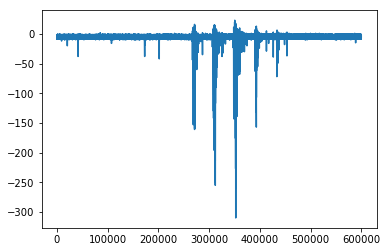

In [5]:
single_trace=tofdata.sel(trainId=108779907)
plt.plot(single_trace)
plt.show()

you can also plot a single trace by index and show the corresponding train id in the title:

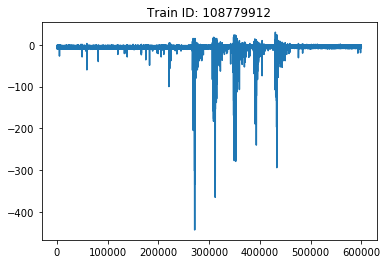

In [6]:
single_trace=tofdata[5,:]
plt.plot(single_trace)
plt.title("Train ID: "+str(int(single_trace.trainId)))
plt.show()

or you plot an average over all shots in the run - you may also select only the range of the TOF data you are interested in

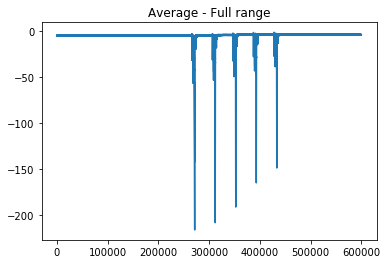

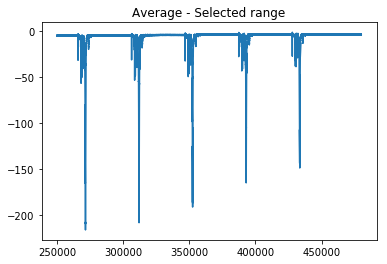

In [7]:
avg_trace=np.mean(tofdata,axis=0)
plt.plot(avg_trace)
plt.title("Average - Full range")
plt.show()

tof_range = range(250000,480000)
plt.plot(tof_range,avg_trace[tof_range])
plt.title("Average - Selected range")
plt.show()

You may want to integrate over certain ranges - we show this for the averaged traces:

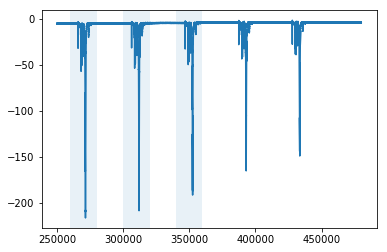

Integrals : [-245047.27 -232601.56 -214115.04]


In [8]:
# make a list of ranges
ranges = list()
# make a list for the integrals
integrals = list()
# add ranges to that list of ranges
ranges.append(range(260000,280000))
ranges.append(range(300000,320000))
ranges.append(range(340000,360000))

#plot tof trace
plt.plot(tof_range,avg_trace[tof_range])
#plot ranges
for i in range(len(ranges)):
    plt.axvspan(min(ranges[i]),max(ranges[i]),alpha=0.1) #plt.axvspan(min x , max x , alpha=0.1 makes transpancy - 0 fully transparent, 1 not transparent)
plt.show() # give out the plot and show it in notebook

#do the integrals
for i in range(len(ranges)): # this is a for loop equal to for i = 0:len(ranges) in matlab
    integrals.append(np.sum(avg_trace[ranges[i]]))
#print the results
print("Integrals : " + str(np.asarray(np.round(integrals,2))))

### Do it the easy and convenient way

For the easy and convenient way we have already some default values in place. 

`adata.getTOF()` is the function to get the tof data. (remember: `adata` is used to access data in a convenient fashion)

It takes one required argument, that is the run number e.g. 100.

#### Default Values and Optional Arguments
`dirspec` and `elementspec` are provided, but in case they differ for your case you can call them as keywordarguments in `adata.getTOF`. 

The same goes for `path` here the `raw` directory for the current experiment (2195) is the default value - since we are using a run that we put in the scratch directory, the `path` to the directory containg the run folder(s) is specified as a keywordargument. 

Also the `tof range` may is to specifiy. Here the default value is likely not to be applicable to your situation.

In [28]:
[TOFtrace, TOFrange]  = adata.getTOF(80, tofrange=(142000,142000+400000))
TOFtrace=TOFtrace-1850

It is very simple now to make a simple plot (even with labeled axis) of a single trace selected by index:
(remember the `tof` module will provide helpful functions for plotting and processing)

In [29]:
tof.plotTOF(TOFrange, TOFtrace[5,:])
plt.show()

Or by train id

In [12]:
#tof.plotTOF(TOFrange, TOFtrace.sel(trainId=108779907))

We can also make an average

In [32]:
tof.plotTOF(TOFrange, tof.averageTOF(TOFtrace))

Plot the 100 brightest tof spectra for a run in a waterfall plot
keywordarguments
* `nbright` - number of brightest tof spectra to show
* `threshSum` - eg. if 0.1 a shot is only even considered when its overall integral is at least 10% of the maximum overall integral for the run
* `behlkeAt` - index at which behlke is switched on - everything before is excluded
* `integrateAt` - tofrange over which is integrated to determine the brightest shot

function returns an array with the train id for the xx brightest shots

<IPython.core.display.Javascript object>


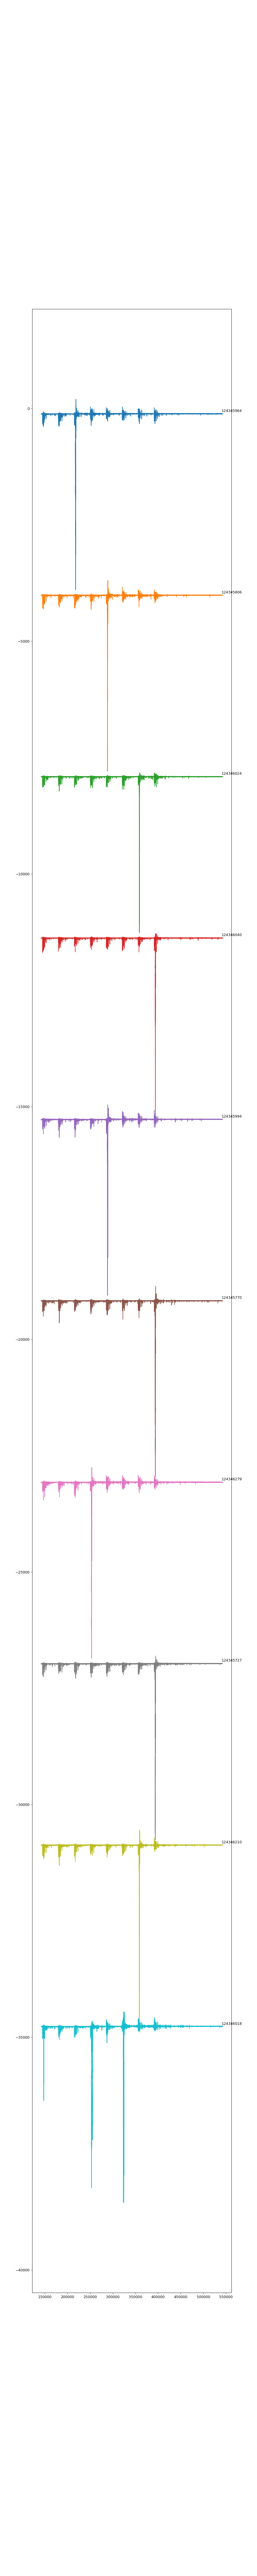

In [33]:
brightest_shots_ids = tof.waterfallBrightest_labelByTrainId(TOFrange, TOFtrace, nbright=10, 
                                      threshSum=0.1, behlkeAt=142000,
                                      integrateAt=(142000 , 542000))

In [34]:
brightest_shots_ids

array([124345964, 124345806, 124346024, 124346040, 124345994, 124345770,
       124346279, 124345727, 124346210, 124346018], dtype=uint64)

In [ ]:
tof.plotTOF(TOFrange, TOFtrace.sel(trainId=124346005))

In [23]:
%matplotlib notebook

In [ ]:
plt.plot( TOFtrace.sel(trainId=124346005))
plt.show()

<IPython.core.display.Javascript object>


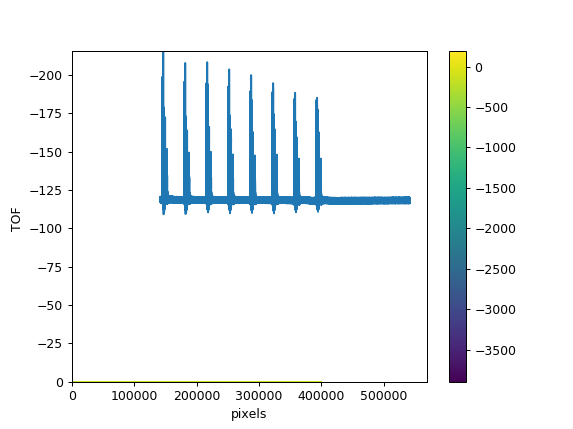

In [31]:
plt.imshow(np.asarray(TOFtrace), aspect='auto')
plt.colorbar()
plt.show()

In [17]:
TOFtrace.shape


(729, 400000)